In [2]:
from sklearn.utils import _pprint
print("Module loaded successfully!")

Module loaded successfully!


In [3]:
%pip install xgboost


[notice] A new release of pip is available: 25.0 -> 25.0.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [4]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
import sklearn
print(sklearn.__version__)
import xgboost
print(xgboost.__version__)
from sklearn.metrics import mean_squared_error
from datetime import datetime, timedelta

1.6.1
3.0.0


In [5]:
df = pd.read_csv(r"/Users/adisayanbose/Developer/final_year_project/train.csv")
df.head()

,YEAR,MO,DY,HR,T2M
0,2001,1,1,0,20.70
1,2001,1,1,1,20.41
2,2001,1,1,2,20.06
3,2001,1,1,3,19.76
4,2001,1,1,4,19.50


### Create datetime index

In [6]:
df['datetime'] = pd.to_datetime(df[['YEAR', 'MO', 'DY', 'HR']].assign(
    YEAR=df.YEAR.astype(str),
    MO=df.MO.astype(str).str.zfill(2),
    DY=df.DY.astype(str).str.zfill(2),
    HR=df.HR.astype(str).str.zfill(2)
).agg('-'.join, axis=1) + ':00')

df = df.set_index('datetime')
df.head()

,YEAR,MO,DY,HR,T2M
datetime,,,,,
2001-01-01 00:00:00,2001,1,1,0,20.70
2001-01-01 01:00:00,2001,1,1,1,20.41
2001-01-01 02:00:00,2001,1,1,2,20.06
2001-01-01 03:00:00,2001,1,1,3,19.76
2001-01-01 04:00:00,2001,1,1,4,19.50


### Feature Engineering

In [7]:
df['hour'] = df.index.hour
df['day'] = df.index.day
df['month'] = df.index.month
df['year'] = df.index.year
df['hour_sin'] = np.sin(2 * np.pi * df['hour']/24)
df['hour_cos'] = np.cos(2 * np.pi * df['hour']/24)
df['day_sin'] = np.sin(2 * np.pi * df['day']/31)
df['day_cos'] = np.cos(2 * np.pi * df['day']/31)
df['month_sin'] = np.sin(2 * np.pi * df['month']/12)
df['month_cos'] = np.cos(2 * np.pi * df['month']/12)
df

,YEAR,MO,DY,HR,T2M,hour,day,month,year,hour_sin,hour_cos,day_sin,day_cos,month_sin,month_cos
datetime,,,,,,,,,,,,,,,
2001-01-01 00:00:00,2001,1,1,0,20.70,0,1,1,2001,0.000000,1.000000,2.012985e-01,0.97953,0.5,8.660254e-01
2001-01-01 01:00:00,2001,1,1,1,20.41,1,1,1,2001,0.258819,0.965926,2.012985e-01,0.97953,0.5,8.660254e-01
2001-01-01 02:00:00,2001,1,1,2,20.06,2,1,1,2001,0.500000,0.866025,2.012985e-01,0.97953,0.5,8.660254e-01
2001-01-01 03:00:00,2001,1,1,3,19.76,3,1,1,2001,0.707107,0.707107,2.012985e-01,0.97953,0.5,8.660254e-01
2001-01-01 04:00:00,2001,1,1,4,19.50,4,1,1,2001,0.866025,0.500000,2.012985e-01,0.97953,0.5,8.660254e-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-03-31 19:00:00,2025,3,31,19,29.88,19,31,3,2025,-0.965926,0.258819,-2.449294e-16,1.00000,1.0,6.123234e-17
2025-03-31 20:00:00,2025,3,31,20,28.75,20,31,3,2025,-0.866025,0.500000,-2.449294e-16,1.00000,1.0,6.123234e-17
2025-03-31 21:00:00,2025,3,31,21,28.08,21,31,3,2025,-0.707107,0.707107,-2.449294e-16,1.00000,1.0,6.123234e-17


### Prepare data for training

In [8]:
FEATURES = ['hour', 'day', 'month', 'year', 
           'hour_sin', 'hour_cos', 
           'day_sin', 'day_cos',
           'month_sin', 'month_cos']
TARGET = 'T2M'

X = df[FEATURES]
y = df[TARGET]

### Split the data

In [9]:
train_size = int(len(df) * 0.8)
X_train = X[:train_size]
y_train = y[:train_size]
X_test = X[train_size:]
y_test = y[train_size:]
import xgboost
print(xgboost.__version__)

3.0.0


### Train XGBOOST model

In [10]:
reg = xgb.XGBRegressor(
    base_score=0.5,
    booster='gbtree',
    n_estimators=500,
    learning_rate=0.15,
    max_depth=10,
    min_child_weight=6,
    subsample=0.8,
    colsample_bytree=0.8,
    gamma=0.5,
    reg_alpha=0,
    reg_lambda=1,
    objective='reg:squarederror',
    early_stopping_rounds=50,
    random_state=69
)


reg.fit(
    X_train, 
    y_train,
    eval_set=[(X_train, y_train), (X_test, y_test)],
    verbose=100
)

[0]	validation_0-rmse:23.87772	validation_1-rmse:23.55895
[74]	validation_0-rmse:0.81835	validation_1-rmse:2.00009


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=0.5, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.15, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=10,
             max_leaves=None, min_child_weight=6, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=500,
             n_jobs=None, num_parallel_tree=None, ...)

In [11]:
train_preds = reg.predict(X_train)
test_preds = reg.predict(X_test)

In [12]:
train_rmse = np.sqrt(mean_squared_error(y_train, train_preds))
test_rmse = np.sqrt(mean_squared_error(y_test, test_preds))
print(f'Train RMSE: {train_rmse:.4f}')
print(f'Test RMSE: {test_rmse:.4f}')

Train RMSE: 1.3686
Test RMSE: 1.7543


In [13]:
print(y_train)
print("-----------------------")
print(y_test)
print("------------------------")

datetime
2001-01-01 00:00:00    20.70
2001-01-01 01:00:00    20.41
2001-01-01 02:00:00    20.06
2001-01-01 03:00:00    19.76
2001-01-01 04:00:00    19.50
                       ...  
2020-05-25 14:00:00    41.42
2020-05-25 15:00:00    40.41
2020-05-25 16:00:00    38.70
2020-05-25 17:00:00    36.27
2020-05-25 18:00:00    33.59
Name: T2M, Length: 170035, dtype: float64
-----------------------
datetime
2020-05-25 19:00:00    31.73
2020-05-25 20:00:00    30.66
2020-05-25 21:00:00    30.01
2020-05-25 22:00:00    29.54
2020-05-25 23:00:00    29.17
                       ...  
2025-03-31 19:00:00    29.88
2025-03-31 20:00:00    28.75
2025-03-31 21:00:00    28.08
2025-03-31 22:00:00    27.61
2025-03-31 23:00:00    27.19
Name: T2M, Length: 42509, dtype: float64
------------------------


### Forecast for the next 30 days


### Plotting the results

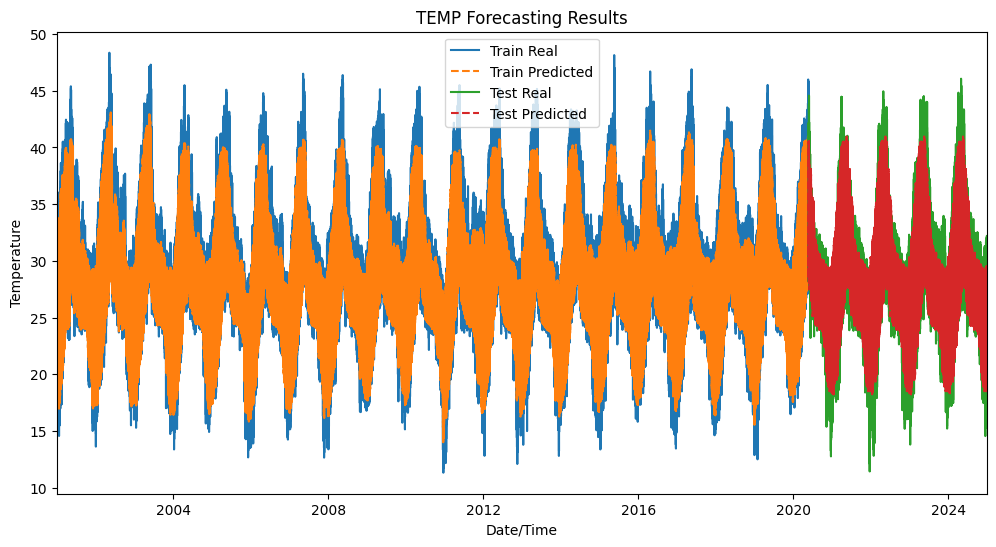

In [14]:
import datetime

plt.figure(figsize=(12, 6))
plt.plot(df.index[:train_size], y_train, label='Train Real')
plt.plot(df.index[:train_size], train_preds, label='Train Predicted', linestyle='--')

plt.plot(df.index[train_size:], y_test, label='Test Real')
plt.plot(df.index[train_size:], test_preds, label='Test Predicted', linestyle='--')

plt.title("TEMP Forecasting Results")
plt.xlabel("Date/Time")
plt.ylabel("Temperature")
plt.legend()

# Convert strings to datetime objects
start_date = datetime.datetime(2001, 1, 1)
end_date = datetime.datetime(2024, 12, 31)
plt.xlim([start_date, end_date])

plt.show()


In [15]:
# Generate future dates for forecasting (next 20 days)
last_date = df.index[-1]
future_dates = pd.date_range(start=last_date + timedelta(hours=1), 
                           periods=24*30,  # 30 days * 24 hours
                           freq='h')

In [16]:
future_df = pd.DataFrame(index=future_dates)
future_df['hour'] = future_df.index.hour
future_df['day'] = future_df.index.day
future_df['month'] = future_df.index.month
future_df['year'] = future_df.index.year
future_df['hour_sin'] = np.sin(2 * np.pi * future_df['hour']/24)
future_df['hour_cos'] = np.cos(2 * np.pi * future_df['hour']/24)
future_df['day_sin'] = np.sin(2 * np.pi * future_df['day']/31)
future_df['day_cos'] = np.cos(2 * np.pi * future_df['day']/31)
future_df['month_sin'] = np.sin(2 * np.pi * future_df['month']/12)
future_df['month_cos'] = np.cos(2 * np.pi * future_df['month']/12)

# Make predictions for future dates
future_predictions = reg.predict(future_df[FEATURES])

In [17]:
# Create DataFrame with predictions
forecast_df = pd.DataFrame({
    'datetime': future_dates,
    'predicted_temp': future_predictions
}).set_index('datetime')


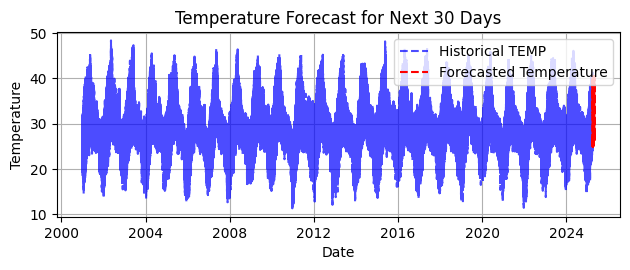

In [18]:
# Plot forecasts
plt.subplot(2, 1, 2)
plt.plot(df.index, df['T2M'], label='Historical TEMP', color='blue', alpha=0.7,linestyle='--')
plt.plot(forecast_df.index, forecast_df['predicted_temp'], 
         label='Forecasted Temperature', color='red', linestyle='--')
plt.title('Temperature Forecast for Next 30 Days')
plt.xlabel('Date')
plt.ylabel('Temperature')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


In [19]:
# Print forecast statistics
print("\nForecast Statistics:")
print(f"Mean Temperature: {forecast_df['predicted_temp'].mean():.2f}")
print(f"Max Temperature: {forecast_df['predicted_temp'].max():.2f}")
print(f"Min Temperature: {forecast_df['predicted_temp'].min():.2f}")

# Print hourly forecasts for the first day
print("\nHourly Forecasts for next 30 days:")
print(forecast_df)

# Save forecasts to CSV
forecast_df.to_csv('temperature_data.csv')


Forecast Statistics:
Mean Temperature: 31.92
Max Temperature: 40.60
Min Temperature: 24.84

Hourly Forecasts for next 30 days:
                     predicted_temp
datetime                           
2025-04-01 00:00:00       26.262415
2025-04-01 01:00:00       25.865025
2025-04-01 02:00:00       25.482828
2025-04-01 03:00:00       25.294687
2025-04-01 04:00:00       25.085691
...                             ...
2025-04-30 19:00:00       30.879637
2025-04-30 20:00:00       29.787827
2025-04-30 21:00:00       29.040104
2025-04-30 22:00:00       28.440973
2025-04-30 23:00:00       28.033455

[720 rows x 1 columns]


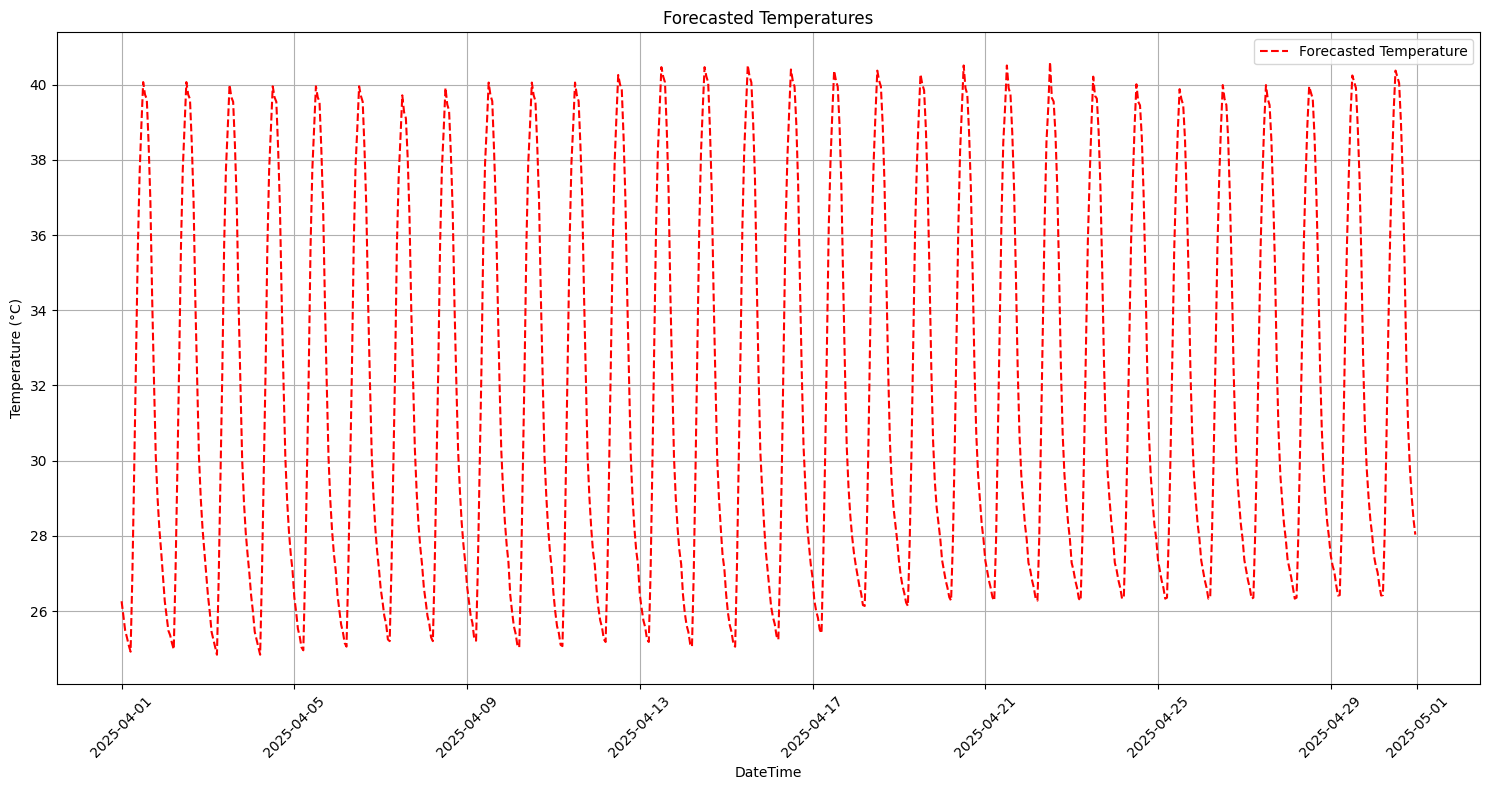

In [24]:
# Import the new temperature data
file_path = r'/Users/adisayanbose/Developer/final_year_project/test.csv'
new_temps = pd.read_csv(file_path)

new_temps['datetime'] = pd.to_datetime(new_temps[['YEAR', 'MO', 'DY', 'HR']].assign(
    YEAR=new_temps.YEAR.astype(str),
    MO=new_temps.MO.astype(str).str.zfill(2),
    DY=new_temps.DY.astype(str).str.zfill(2),
    HR=new_temps.HR.astype(str).str.zfill(2)
).agg('-'.join, axis=1) + ':00')

new_temps = new_temps.set_index('datetime')

# Ensure the time periods match
forecast_subset = forecast_df
actual_subset = new_temps

# Create comparison plot
plt.figure(figsize=(15, 8))

# Plot both forecasted and actual temperatures
plt.plot(forecast_subset.index, forecast_subset['predicted_temp'], 
         label='Forecasted Temperature', 
         color='red', 
         linestyle='--')


# Customize the plot
plt.title('Forecasted Temperatures')
plt.xlabel('DateTime')
plt.ylabel('Temperature (°C)')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()


In [21]:
# # Calculate and print comparison metrics
# from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# comparison_metrics = {
#     'RMSE': np.sqrt(mean_squared_error(actual_subset['T2M'], forecast_subset['predicted_temp'])),
#     'MAE': mean_absolute_error(actual_subset['T2M'], forecast_subset['predicted_temp']),
#     'R2': r2_score(actual_subset['T2M'], forecast_subset['predicted_temp'])
# }

# print("\nComparison Metrics:")
# for metric, value in comparison_metrics.items():
#     print(f"{metric}: {value:.4f}")

# # Create a comparison DataFrame
# comparison_df = pd.DataFrame({
#     'Actual': actual_subset['T2M'],
#     'Forecasted': forecast_subset['predicted_temp'],
#     'Difference': actual_subset['T2M'] - forecast_subset['predicted_temp']
# })

# print("\nHourly Comparison:")
# print(comparison_df)


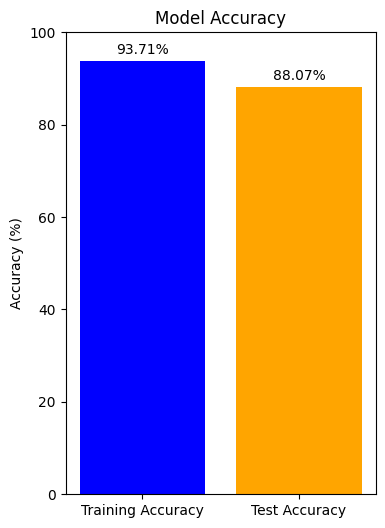

In [22]:
import matplotlib.pyplot as plt
accuracy_train = reg.score(X_train, y_train) * 100
accuracy_test = reg.score(X_test, y_test) * 100
# Define the accuracies and their labels
accuracies = [accuracy_train, accuracy_test]
labels = ['Training Accuracy', 'Test Accuracy']

plt.figure(figsize=(4, 6))
bars = plt.bar(labels, accuracies, color=['blue', 'orange'])

# Add accuracy values on top of each bar
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 1, f'{height:.2f}%', 
             ha='center', va='bottom')

plt.ylabel('Accuracy (%)')
plt.title('Model Accuracy')
plt.ylim(0, 100)  # Set y-axis from 0% to 100%
plt.show()


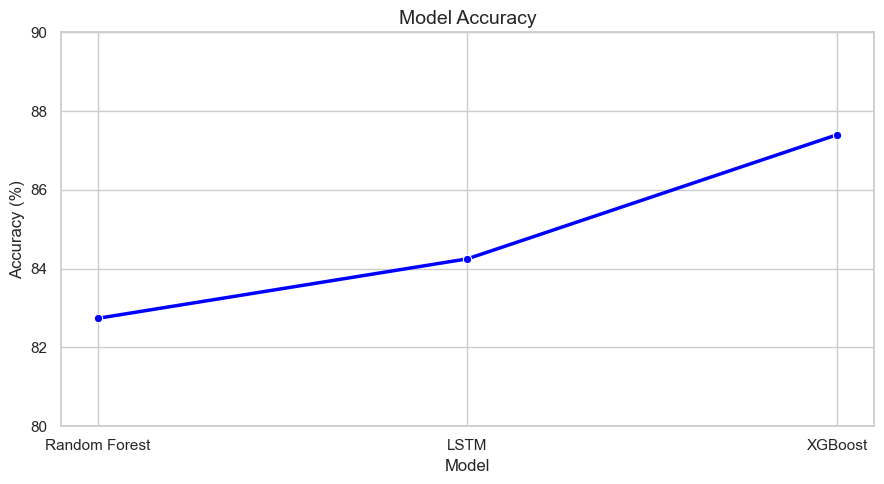

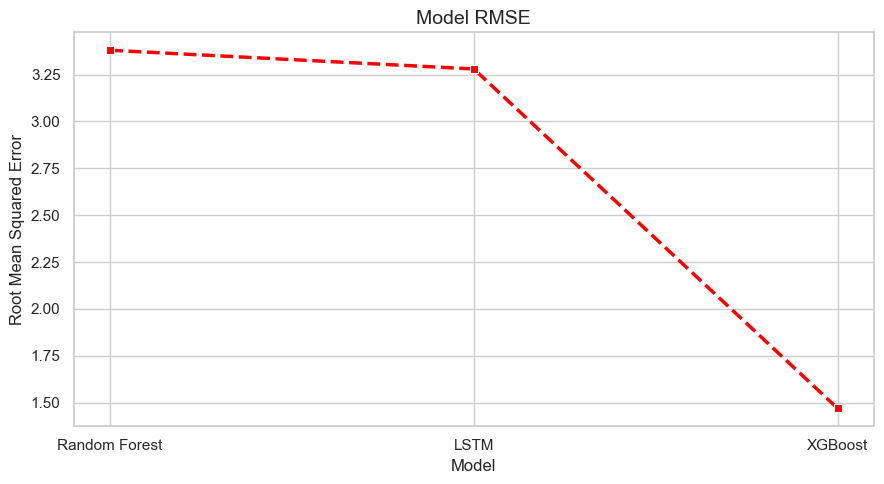

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Data
data = {
    'Model': ['Random Forest', 'LSTM', 'XGBoost'],
    'Accuracy': [82.74, 84.25, 87.4],
    'RMSE': [3.38, 3.28, 1.47]
}
df = pd.DataFrame(data)

# Seaborn style
sns.set(style="whitegrid")

# Plot 1: Accuracy Line Plot
plt.figure(figsize=(9, 5))
sns.lineplot(data=df, x='Model', y='Accuracy', marker='o', linewidth=2.5, color='blue')
plt.title('Model Accuracy', fontsize=14)
plt.ylabel('Accuracy (%)')
plt.ylim(80, 90)
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot 2: RMSE Line Plot
plt.figure(figsize=(9, 5))
sns.lineplot(data=df, x='Model', y='RMSE', marker='s', linewidth=2.5, linestyle='--', color='red')
plt.title('Model RMSE', fontsize=14)
plt.ylabel('Root Mean Squared Error')
plt.grid(True)
plt.tight_layout()
plt.show()